In [14]:
import argparse
import logging.config
import os
from collections import defaultdict

from dotenv import load_dotenv

from rescueclip.logging_config import LOGGING_CONFIG

logging.config.dictConfig(LOGGING_CONFIG)
logger = logging.getLogger(__name__)
from pathlib import Path
import matplotlib.pyplot as plt
import time

import numpy as np
from typing import cast, Sequence, List, Any, Literal
import weaviate
from tqdm import tqdm
from weaviate.classes.query import Filter, MetadataQuery
from weaviate.collections.classes.types import Properties, WeaviateProperties
from weaviate.collections.classes.internal import Object
from weaviate.util import generate_uuid5, get_vector

from rescueclip import cuhk
from rescueclip.cuhk import SetNumToImagesMap
from rescueclip.ml_model import (
    CollectionConfig,
    CUHK_Apple_Collection,
    CUHK_Random_Model_Collection,
    CUHK_Google_Siglip_Base_Patch16_224_Collection,
    CUHK_Google_Siglip_SO400M_Patch14_384_Collection,
    CUHK_laion_CLIP_ViT_bigG_14_laion2B_39B_b160k_Collection,
    CUHK_MetaCLIP_ViT_bigG_14_quickgelu_224_Collection,
    CUHK_ViT_B_32_Collection,
    CUHK_PDNA_Collection
)
from rescueclip.weaviate import WeaviateClientEnsureReady

load_dotenv()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
collection_config = CUHK_Apple_Collection
client = WeaviateClientEnsureReady().get_client()
collection = client.collections.get(collection_config.name)
QUERY_MAXIMUM_RESULTS = 200_000

number_of_objects: int = collection.aggregate.over_all(total_count=True).total_count # type: ignore
logger.info(f"Number of objects %s", number_of_objects)
assert (
    number_of_objects <= QUERY_MAXIMUM_RESULTS 
), "Ensure docker-compose.yml has QUERY_MAXIMUM_RESULTS to greater than 200_000 or the experiment's results may be inaccurate"

2025-02-24 21:47:12,368 [INFO] rescueclip.weaviate: Weaviate is ready
2025-02-24 21:47:12,374 [INFO] __main__: Number of objects 18596


/scratch3/atharva/anaconda3/envs/rescueCLIP/lib/python3.12/site-packages/weaviate/warnings.py:314: ResourceWarning: Con004: The connection to Weaviate was not closed properly. This can lead to memory leaks.
            Please make sure to close the connection using `client.close()`.
  warnings.warn(


In [16]:
# Train test split
logger.info("Retrieving the entire database into memory")
objects = collection.query.fetch_objects(
    limit=QUERY_MAXIMUM_RESULTS,
    include_vector=True,
    return_properties=True,
).objects
assert len(objects) == number_of_objects, "Expected the entire database to be retrieved"

objects.sort(key=lambda obj: (obj.properties["set_number"], obj.properties["file_name"]))

##### TEMPORARITY MAKE DATASET SMALLER
objects = objects[:8*4] # 4 sets of 4 images each
#####

# (N, D)
X = np.array([obj.vector["embedding"] for obj in objects])
y_set_labels = np.array([obj.properties["set_number"] for obj in objects])
N = X.shape[0]
D = X.shape[1]
assert N % 4 == 0, "Expected the number of images to be divisible by 4"
assert y_set_labels.shape[0] == N, "Expected the number of objects to match the number of set labels"

logger.info(f"N: {N}")
logger.info(f"D: {N}")

### Random Shuffle
# X = X.reshape(-1, 4, X.shape[-1])
# y_set_labels = y_set_labels.reshape(-1, 4)
# assert X.shape == (N // 4, 4, D), f"X.shape: {X.shape}"
# assert y_set_labels.shape == (N//4, 4), f"y_set_labels.shape: {y_set_labels.shape}"
# logger.info(f"X.shape after grouping into sets: {X.shape}")
# logger.info(f"y_set_labels.shape after grouping into sets: {y_set_labels.shape}")

# if not X.shape[0] % 4 == 0:
#     logger.info(f"Expected the number of sets to be divisible by 4, {X.shape[0]} is not divisible by 4")
#     logger.info(f"Removing {X.shape[0] % 4} sets")
#     X = X[:-(X.shape[0] % 4)]
#     y_set_labels = y_set_labels[:-(y_set_labels.shape[0] % 4)]
#     logger.info(f"X.shape after removing extra sets: {X.shape}")
#     logger.info(f"y_set_labels.shape after removing extra sets: {y_set_labels.shape}")
#     N = X.shape[0] * X.shape[1]
#     logger.info(f"N: {N}")
#     logger.info(f"D: {N}")

# perm = np.random.permutation(X.shape[0])

# X = X[perm]
# y_set_labels = y_set_labels[perm]
# X = X.reshape(-1, X.shape[-1])
# y_set_labels = y_set_labels.reshape(-1)
# assert X.shape == (N, D), f"X.shape: {X.shape}"
# assert y_set_labels.shape == (N,), f"y_set_labels.shape: {y_set_labels.shape}"
### End Random Shuffle

##### TEMPORARITY ASSERTIONS
assert N == 8*4, "Expected 16 objects"
assert y_set_labels.shape[0] == 8*4, "Expected 16 objects"
# assert (np.unique(y_set_labels) == np.array([1, 4, 8, 9])).all(), "Expected the set labels to be 0, 1, 2, 3, got {}".format(np.unique(y_set_labels))
#####

logger.info(f"X.shape: {X.shape}")
logger.info(f"y_set_labels.shape: {y_set_labels.shape}")

2025-02-24 21:47:12,420 [INFO] __main__: Retrieving the entire database into memory
2025-02-24 21:47:15,024 [INFO] __main__: N: 32
2025-02-24 21:47:15,025 [INFO] __main__: D: 32
2025-02-24 21:47:15,026 [INFO] __main__: X.shape: (32, 1024)
2025-02-24 21:47:15,027 [INFO] __main__: y_set_labels.shape: (32,)


In [17]:
assert N % 2 == 0, "Can't evenly split the data into train and test sets"
# (N//2, D)
X_train_vectors = X[:N//2, :]
# (N//2, D)
X_test_vectors = X[N//2:, :]

logger.info(f"X_train_vectors.shape: {X_train_vectors.shape}")
logger.info(f"X_test_vectors.shape: {X_test_vectors.shape}")

2025-02-24 21:47:15,070 [INFO] __main__: X_train_vectors.shape: (16, 1024)
2025-02-24 21:47:15,071 [INFO] __main__: X_test_vectors.shape: (16, 1024)


In [18]:
from scipy.spatial.distance import cdist

X_train_distances = cdist(X_train_vectors, X_train_vectors, metric='cosine')
y_train_labels = y_set_labels[:N//2]

logger.info("X_train_distances.shape: {}".format(X_train_distances.shape))
logger.info("y_train_labels.shape: {}".format(y_train_labels.shape))

2025-02-24 21:47:15,106 [INFO] __main__: X_train_distances.shape: (16, 16)
2025-02-24 21:47:15,107 [INFO] __main__: y_train_labels.shape: (16,)


In [19]:
print(f"{X_train_distances[:5, :5]}")
print(f"{y_train_labels[:5]}")

[[0.         0.15403616 0.1994384  0.37220493 0.31865613]
 [0.15403616 0.         0.12657806 0.34442987 0.36794799]
 [0.1994384  0.12657806 0.         0.28237242 0.30409882]
 [0.37220493 0.34442987 0.28237242 0.         0.35346233]
 [0.31865613 0.36794799 0.30409882 0.35346233 0.        ]]
[1 1 1 1 4]


In [20]:
X_test_distances = cdist(X_train_vectors, X_test_vectors, metric='cosine')
y_test_labels = y_set_labels[N//2:]

logger.info(f"X_test_distances.shape: {X_test_distances.shape}")
logger.info(f"y_test_labels.shape: {y_test_labels.shape}")

2025-02-24 21:47:15,170 [INFO] __main__: X_test_distances.shape: (16, 16)
2025-02-24 21:47:15,171 [INFO] __main__: y_test_labels.shape: (16,)


In [21]:
print(f"{X_test_distances[:5, :5]}")
print(f"{y_test_labels[:5]}")

[[0.28333559 0.33047312 0.34653108 0.31445658 0.3856438 ]
 [0.27105734 0.32344911 0.33743989 0.29936397 0.42529545]
 [0.19674998 0.24225063 0.27543863 0.24831986 0.32705583]
 [0.36356342 0.43358694 0.38659531 0.27550847 0.4069046 ]
 [0.38863915 0.4355173  0.34299942 0.29078703 0.25449726]]
[10 10 10 10 14]


In [22]:
try:
    del X
    del y_set_labels
except:
    pass

In [23]:
# For train data
sorted_indexes = np.argsort(X_train_distances, axis=1)
print(f"sorted_indexes[:8, :8]=\n{sorted_indexes[:8, :8]}")
assertion_cond = (np.arange(N//2) == sorted_indexes[:, 0])
if not np.all(assertion_cond):
    false_indices = np.flatnonzero(~assertion_cond)
    logger.info(f"Fixing distances at positions: {false_indices}")
    for false_index in false_indices:
        logger.info(f"Swapping index: {false_index}")
        temp = sorted_indexes[false_index, 0]
        sorted_indexes[false_index, 0] = sorted_indexes[false_index, 1]
        sorted_indexes[false_index, 1] = temp
    assertion_cond = (np.arange(N//2) == sorted_indexes[:, 0])
    if not np.all(assertion_cond):
        false_indices = np.flatnonzero(~assertion_cond)
        assert False, f"Expected the first column of the sorted indexes to be the same as the original indexes\n{false_indices=}\n{sorted_indexes[false_indices[0] - 3:false_indices[0] + 3, :]=}"

X_train_distances = np.take_along_axis(X_train_distances, sorted_indexes, axis=1)
y_train_labels_mat = y_train_labels[sorted_indexes]
del sorted_indexes
print(f"{X_train_distances[:5, :5]}")
print(f"{y_train_labels_mat[:8, :8]}")

logger.info(f"X_train_distances.shape: {X_train_distances.shape}")
logger.info(f"y_set_labels_mat.shape: {y_train_labels_mat.shape}")


sorted_indexes[:8, :8]=
[[ 0  1  2  9  4 10 11  3]
 [ 1  2  0  3 11 10  9  4]
 [ 2  1  0  3  4  7 13 11]
 [ 3  2  7  1  4 12  0  9]
 [ 4  7  5  6 12  2 14 15]
 [ 5  6  4  7  0  2 12  1]
 [ 6  5  4  7  2 14 12 15]
 [ 7  4  6  5  3  2 12 14]]
[[0.         0.15403616 0.1994384  0.3185329  0.31865613]
 [0.         0.12657806 0.15403616 0.34442987 0.35034101]
 [0.         0.12657806 0.1994384  0.28237242 0.30409882]
 [0.         0.28237242 0.30199488 0.34442987 0.35346233]
 [0.         0.15919677 0.16148773 0.20037463 0.29205682]]
[[1 1 1 8 4 8 8 1]
 [1 1 1 1 8 8 8 4]
 [1 1 1 1 4 4 9 8]
 [1 1 4 1 4 9 1 8]
 [4 4 4 4 9 1 9 9]
 [4 4 4 4 1 1 9 1]
 [4 4 4 4 1 9 9 9]
 [4 4 4 4 1 1 9 9]]
2025-02-24 21:47:15,269 [INFO] __main__: X_train_distances.shape: (16, 16)
2025-02-24 21:47:15,270 [INFO] __main__: y_set_labels_mat.shape: (16, 16)


In [24]:
# For test distances
sorted_indexes = np.argsort(X_test_distances, axis=1)
print(f"sorted_indexes[:8, :8]=\n{sorted_indexes[:8, :8]}")

X_test_distances = np.take_along_axis(X_test_distances, sorted_indexes, axis=1)
y_test_labels_mat = y_test_labels[sorted_indexes]
del sorted_indexes
print(f"{X_test_distances[:5, :5]}")
print(f"{y_test_labels_mat[:8, :8]}")

logger.info(f"X_test_distances.shape: {X_test_distances.shape}")
logger.info(f"y_test_labels_mat.shape: {y_test_labels_mat.shape}")

sorted_indexes[:8, :8]=
[[12  0 14 13  3  1  2 15]
 [12  0 14 13  3  1  2 15]
 [ 0 12  1 14  3 13  2 15]
 [ 3 14 15 13 12  0  8  2]
 [10  9 11  8  4 13  6  5]
 [10 11  9 13 12  8  4 14]
 [10  9 11  8 13 12 15  4]
 [ 8 15 11 10  3  9 13 14]]
[[0.26684031 0.28333559 0.28839424 0.29721726 0.31445658]
 [0.24320469 0.27105734 0.28114523 0.28626894 0.29936397]
 [0.19674998 0.2348816  0.24225063 0.24493872 0.24831986]
 [0.27550847 0.27845903 0.2809459  0.35406035 0.36319902]
 [0.18141295 0.19765169 0.23469656 0.23808648 0.25449726]]
[[21 10 21 21 10 10 10 21]
 [21 10 21 21 10 10 10 21]
 [10 21 10 21 10 21 10 21]
 [10 21 21 21 21 10 15 10]
 [15 15 15 15 14 21 14 14]
 [15 15 15 21 21 15 14 21]
 [15 15 15 15 21 21 21 14]
 [15 21 15 15 10 15 21 21]]
2025-02-24 21:48:46,869 [INFO] __main__: X_test_distances.shape: (16, 16)
2025-02-24 21:48:46,870 [INFO] __main__: y_test_labels_mat.shape: (16, 16)


In [58]:
def compute_result_naive(X, y_set_labels_mat, y_set_labels, t, is_train: bool):
    N = X.shape[0]
    result = np.zeros(N, dtype=int)
    
    for i in range(N):
        # Since X[i] is sorted in ascending order, find the cutoff index.
        # This returns the index at which t should be inserted to maintain order,
        # meaning all indices below this are <= t.
        k = np.searchsorted(X[i], t, side='right')
        
        # Get the labels for these positions
        selected_labels = y_set_labels_mat[i, :k]
        
        # Count how many times the label equals y_set_labels[i]
        count = np.sum(selected_labels == y_set_labels[i])

        # If is train, and t is suffiently large, make sure than the count is at least 1
        if is_train and t > 0.05:
            assert count >= 1, f"count: {count}, t: {t}, i: {i}, k: {k}"
        
        # If the count is at least 2, set result[i] to 1
        if (is_train and count >= 2):
            result[i] = 1
        elif not is_train:
            # If there are any distances less than t for the test data, we can a False Positive
            result[i] = 1 if k > 0 else 0
            
    return result

def compute_result_vectorized(X, y_set_labels_mat, y_set_labels, t, is_train):
    # Create a mask where each element is True if X[i, j] <= t.
    mask_threshold = X <= t  # shape (N, N)
    
    # Create a mask where each element is True if y_set_labels_mat[i, j] equals y_set_labels[i].
    label_match = (y_set_labels_mat == y_set_labels[:, np.newaxis])
    
    # Combine the masks to consider only the positions meeting both conditions.
    combined_mask = mask_threshold & label_match
    
    # Count the matches in each row.
    count = np.sum(combined_mask, axis=1)

    # If is train, and t is suffiently large, make sure than the count is at least 1
    if is_train and t > 0.05:
        assertion_cond = count >= 1
        if not np.all(assertion_cond):
            false_indices = np.flatnonzero(~assertion_cond)
            assert False, f"count: {count}, t: {t}, at index: {false_indices[0]}"
    
    # Result is 1 if count >= 2, else 0.
    if is_train:
        result = (count >= 2).astype(int)
    else:
        result = np.where(mask_threshold[:, 0] == False, 0, 1)
    return result

In [59]:
from dataclasses import dataclass

@dataclass
class ConfusionMatrix:
    tp: int | np.floating = 0
    tn: int | np.floating = 0
    fp: int | np.floating = 0
    fn: int | np.floating = 0

    def update(self, *, tp: int | np.floating = 0, tn: int | np.floating = 0, fp: int | np.floating = 0, fn: int | np.floating = 0):
        self.tp += tp
        self.tn += tn
        self.fp += fp
        self.fn += fn

    def as_array(self):
        # Returns a 2x2 array: [[tn, fp], [fn, tp]]
        return [[self.tn, self.fp], [self.fn, self.tp]]
    
    # how often predictions for the positive class are correct
    def precision(self):
        if self.tp + self.fp == 0:
            return 0.0
        return self.tp / (self.tp + self.fp)

    # proportion of all actual positives (in the DB) that were classified correctly as positives
    def recall(self):
        if self.tp + self.fn == 0:
            return 0.0
        return self.tp / (self.tp + self.fn)

    def f1(self):
        prec = self.precision()
        rec = self.recall()
        if prec + rec == 0:
            return 0.0
        return 2 * (prec * rec) / (prec + rec)
    
    # the probability of a test incorrectly identifying a negative result (not in DB) as positive
    def fpr(self):
        if self.fp + self.tn == 0:
            return 0.0
        return self.fp / (self.fp + self.tn)
    
    def __str__(self):
        return f"TP: {self.tp}, TN: {self.tn}, FP: {self.fp}, FN: {self.fn}"



In [60]:
def threshold_test(t, X_train_distances, y_train_labels_mat, y_train_labels, X_test_distances, y_test_labels_mat, y_test_labels) -> ConfusionMatrix:
    # Training results
    training_set_results = compute_result_naive(X_train_distances, y_train_labels_mat, y_train_labels, t, True)
    assert training_set_results.shape[0] == X_train_distances.shape[0] == y_train_labels_mat.shape[0] == y_train_labels.shape[0], f"Dimension check failed {training_set_results.shape[0]=} {X_train_distances.shape[0]=} {y_train_labels_mat.shape[0]=} {y_train_labels.shape[0]=}"

    training_counts = np.unique_counts(training_set_results)
    assert len(training_counts.counts) <= 2, f"Expected <= 2 values, got {training_counts}"

    # Testing results
    test_set_results = compute_result_naive(X_test_distances, y_test_labels_mat, y_test_labels, t, False)
    assert test_set_results.shape[0] == X_test_distances.shape[0] == y_test_labels_mat.shape[0] == y_test_labels.shape[0], f"Dimension check failed {test_set_results.shape[0]=} {X_test_distances.shape[0]=} {y_test_labels_mat.shape[0]=} {y_test_labels.shape[0]=}"

    testing_counts = np.unique_counts(test_set_results)
    assert len(testing_counts.counts) <= 2, f"Expected <= 2 values, got {testing_counts}"

    # Confusion matrix
    cm = ConfusionMatrix()
    if len(training_counts.counts) == 2:
        tp = training_counts.counts[1]
        fn = training_counts.counts[0]
    elif len(training_counts.counts) == 1:
        count_for = training_counts.values[0]
        if count_for == 1:
            tp = training_counts.counts[0]
            fn = 0
        elif count_for == 0:
            tp = 0
            fn = training_counts.counts[0]
        else:
            raise ValueError(f"Unexpected value {count_for}")
    else:
        raise ValueError(f"Unexpected value {training_counts}")

    if len(testing_counts.counts) == 2:
        tn = testing_counts.counts[0]
        fp = testing_counts.counts[1]
    elif len(testing_counts.counts) == 1:
        count_for = testing_counts.values[0]
        if count_for == 1:
            fp = testing_counts.counts[0]
            tn = 0
        elif count_for == 0:
            fp = 0
            tn = testing_counts.counts[0]
        else:
            raise ValueError(f"Unexpected value {count_for}")
    else:
        raise ValueError(f"Unexpected value {testing_counts}")

    cm.update(tp=tp, tn=tn, fp=fp, fn=fn)
    
    return cm

In [61]:
X_train_distances

array([[0.00000000e+00, 8.50979620e-01, 8.54167801e-01, ...,
        1.15846539e+00, 1.16423065e+00, 1.17730020e+00],
       [0.00000000e+00, 8.32059643e-01, 8.51864994e-01, ...,
        1.14604566e+00, 1.15063428e+00, 1.15313163e+00],
       [0.00000000e+00, 8.10816860e-01, 8.23159275e-01, ...,
        1.15454096e+00, 1.15673707e+00, 1.15775984e+00],
       ...,
       [0.00000000e+00, 8.15778922e-01, 8.47467547e-01, ...,
        1.15896981e+00, 1.17128510e+00, 1.17311240e+00],
       [0.00000000e+00, 8.37066619e-01, 8.37924403e-01, ...,
        1.14776647e+00, 1.15805116e+00, 1.16478630e+00],
       [1.11022302e-16, 8.25154695e-01, 8.38552234e-01, ...,
        1.15070979e+00, 1.15461441e+00, 1.15878834e+00]])

In [62]:
y_train_labels_mat

array([[   1, 5935, 6147, ..., 4809,  775,  420],
       [   1, 6082, 3613, ..., 4985, 5555, 1937],
       [   1, 1959, 2007, ..., 1142,  444, 6407],
       ...,
       [6475, 5161,  587, ..., 5403, 2687, 2789],
       [6480, 5325, 4023, ..., 5638, 2917, 2427],
       [6480, 4504,   98, ..., 3989, 3697, 2569]])

In [63]:
y_train_labels

array([   1,    1,    1, ..., 6475, 6480, 6480])

In [64]:
# Smoke test
t = 1.55e-01
tic = time.time()
cm = threshold_test(t, X_train_distances, y_train_labels_mat, y_train_labels, X_test_distances, y_test_labels_mat, y_test_labels)
toc = time.time()
logger.info(f"Threshold: {t}")
logger.info(f"Time taken: {toc - tic}")
logger.info(f"{cm}")
logger.info(f"Precision: {cm.precision()}")
logger.info(f"Recall: {cm.recall()}")
logger.info(f"FPR: {cm.fpr()}")
logger.info(f"F1: {cm.f1()}")

2025-02-24 16:44:57,391 [INFO] __main__: Threshold: 0.155
2025-02-24 16:44:57,392 [INFO] __main__: Time taken: 0.15468502044677734
2025-02-24 16:44:57,392 [INFO] __main__: TP: 0, TN: 9298, FP: 0, FN: 9298
2025-02-24 16:44:57,393 [INFO] __main__: Precision: 0.0
2025-02-24 16:44:57,393 [INFO] __main__: Recall: 0.0
2025-02-24 16:44:57,394 [INFO] __main__: FPR: 0.0
2025-02-24 16:44:57,394 [INFO] __main__: F1: 0.0


In [65]:
from rescueclip import sqlite_db
from rescueclip.sqlite_db import ThresholdTest


DATABASE_PATH = os.environ["MOD_DATABASE_PATH"]

def save_results_to_db(results: dict[float, ConfusionMatrix]):
    session = sqlite_db.initialize(f"sqlite:///{DATABASE_PATH}")
    for threshold, confusion_matrix in results.items():
        assert sqlite_db.try_insert(ThresholdTest(
            model_name=collection_config.model_config.model_name,
            threshold=threshold,
            tp=int(confusion_matrix.tp),
            fp=int(confusion_matrix.fp),
            tn=int(confusion_matrix.tn),
            fn=int(confusion_matrix.fn),
        ), session), "could not insert threshold test"

In [66]:
results: dict[float, ConfusionMatrix] = {}
N_THRESHOLDS = 400
for t in tqdm(np.linspace(0, 1, N_THRESHOLDS), total=N_THRESHOLDS):
    cm = threshold_test(t, X_train_distances, y_train_labels_mat, y_train_labels, X_test_distances, y_test_labels_mat, y_test_labels)
    results[t] = cm


100%|██████████| 400/400 [00:56<00:00,  7.10it/s]


In [67]:
save_results_to_db(results)

In [68]:
from sqlalchemy import select
from rescueclip.sqlite_db import ThresholdTest
from rescueclip import sqlite_db

DATABASE_PATH = os.environ["MOD_DATABASE_PATH"]

def load_results() -> dict[str, dict[float, ConfusionMatrix]]:
    session = sqlite_db.initialize(f"sqlite:///{DATABASE_PATH}")
    
    stmt = select(
        ThresholdTest.model_name,
        ThresholdTest.threshold,
        ThresholdTest.tp,
        ThresholdTest.fp,
        ThresholdTest.tn,
        ThresholdTest.fn
    )
    result = session.execute(stmt).fetchall()

    result_curves = defaultdict(dict)
    for row in result:
        model_name, threshold, tp, fp, tn, fn = row
        cm = ConfusionMatrix(tp=tp, fp=fp, tn=tn, fn=fn)
        
        # If the model_name is already in the dictionary, add the threshold and cm.
        # Otherwise, create a new inner dictionary.
        result_curves[model_name][threshold] = cm

    return result_curves

In [69]:
def has_violations(value_list, increasing=True):
    violations = []

    for i in range(1, len(value_list)):
        if increasing:
            if value_list[i] < value_list[i - 1]:
                violations.append(i)
        else:
            if value_list[i] > value_list[i - 1]:
                violations.append(i)
    if not violations:
        return False
    else:
        for i in violations:
            print(f"Violation at index {i}: value_list[{i}] = {value_list[i]}")
        return True

In [70]:
# results_curves = {collection_config.model_config.model_name: results}
results_curves = load_results()
results_curves

defaultdict(dict,
            {'hf-hub:apple/DFN5B-CLIP-ViT-H-14-384': {0.0: ConfusionMatrix(tp=16, tn=9297, fp=1, fn=9282),
              0.002506265664160401: ConfusionMatrix(tp=18, tn=9297, fp=1, fn=9280),
              0.005012531328320802: ConfusionMatrix(tp=18, tn=9297, fp=1, fn=9280),
              0.007518796992481203: ConfusionMatrix(tp=18, tn=9297, fp=1, fn=9280),
              0.010025062656641603: ConfusionMatrix(tp=18, tn=9297, fp=1, fn=9280),
              0.012531328320802004: ConfusionMatrix(tp=18, tn=9297, fp=1, fn=9280),
              0.015037593984962405: ConfusionMatrix(tp=20, tn=9295, fp=3, fn=9278),
              0.017543859649122806: ConfusionMatrix(tp=20, tn=9295, fp=3, fn=9278),
              0.020050125313283207: ConfusionMatrix(tp=22, tn=9295, fp=3, fn=9276),
              0.022556390977443608: ConfusionMatrix(tp=26, tn=9295, fp=3, fn=9272),
              0.02506265664160401: ConfusionMatrix(tp=42, tn=9295, fp=3, fn=9256),
              0.02756892230576441: C

In [ ]:
# results_curves = {'hf-hub:apple/DFN5B-CLIP-ViT-H-14-384': results_curves['hf-hub:apple/DFN5B-CLIP-ViT-H-14-384']}
# results = results_curves['hf-hub:apple/DFN5B-CLIP-ViT-H-14-384']
# results_items = sorted(results.items(), key=lambda x: x[0])
# results_items[32]

(0.08020050125313283, ConfusionMatrix(tp=3155, tn=7468, fp=1830, fn=6143))

Label: hf-hub:apple/DFN5B-CLIP-ViT-H-14-384
Thresholds: 400
Best F1 idx: 142
Best F1 score: 0.6666905700968089
TPR at Best F1: 0.999892449989245
FPR at Best F1: 0.999677349967735
Best threshold: 0.3558897243107769

Index of threshold at FPR=20%: 32
FPR at 20%: 0.19681651968165198
TPR at 20%: 0.3393202839320284
Threshold at FPR=20%: 0.08020050125313283
F1 at FPR=20%: 0.4417839389484002
Label: ViT-B-32
Thresholds: 400
Best F1 idx: 208
Best F1 score: 0.6666666666666666
TPR at Best F1: 1.0
FPR at Best F1: 1.0
Best threshold: 0.5213032581453634

Index of threshold at FPR=20%: 39
FPR at 20%: 0.198537319853732
TPR at 20%: 0.09163260916326092
Threshold at FPR=20%: 0.09774436090225563
F1 at FPR=20%: 0.14204734911637212
Label: PhotoDNA
Thresholds: 400
Best F1 idx: 229
Best F1 score: 0.6666666666666666
TPR at Best F1: 1.0
FPR at Best F1: 1.0
Best threshold: 0.5739348370927317

Index of threshold at FPR=20%: 44
FPR at 20%: 0.19739897816999535
TPR at 20%: 0.12378077101718532
Threshold at FPR=20%: 0

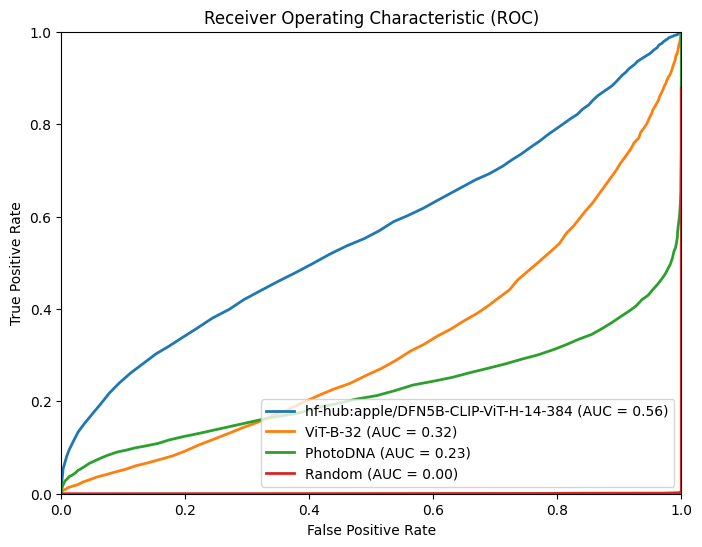

In [ ]:
from sklearn.metrics import auc

from rescueclip.ml_model import LIPModelProvider


plt.figure(figsize=(8, 6))
for label, results in results_curves.items():
    # Extract FPR and TPR for each threshold.
    # Note: Sorting the thresholds ensures the curve is plotted in order.
    thresholds = sorted(results.keys())

    tpr_list = np.array([results[t].recall() for t in thresholds])
    fpr_list = np.array([results[t].fpr() for t in thresholds])
    f1_scores = np.array([results[t].f1() for t in thresholds])

    print(f"Label: {label}")
    print(f"Thresholds: {len(thresholds)}")
    best_f1_idx = np.argmax(f1_scores)
    print(f"Best F1 idx: {best_f1_idx}")
    print(f"Best F1 score: {f1_scores[best_f1_idx]}")
    print(f"TPR at Best F1: {tpr_list[best_f1_idx]}")
    print(f"FPR at Best F1: {fpr_list[best_f1_idx]}")
    print(f"Best threshold: {thresholds[best_f1_idx]}")
    print()

    idx_of_given_fpr = np.abs(fpr_list - 0.2).argmin()
    print(f"Index of threshold at FPR=20%: {idx_of_given_fpr}")
    print(f"FPR at 20%: {fpr_list[idx_of_given_fpr]}")
    print(f"TPR at 20%: {tpr_list[idx_of_given_fpr]}")
    print(f"Threshold at FPR=20%: {thresholds[idx_of_given_fpr]}")
    print(f"F1 at FPR=20%: {f1_scores[idx_of_given_fpr]}")
    
    if has_violations(fpr_list, True):
        print(f"Violations found for FPR list {label}")
    if has_violations(tpr_list, True):
        print(f"Violations found for TPR list {label}")
    
    # Calculate the area under the ROC curve.
    roc_auc = auc(fpr_list, tpr_list)
    
    # if collection_config.model_config.provider == LIPModelProvider.RANDOM:
    #     plt.plot(fpr_list, tpr_list, lw=2, label=f'{label} (AUC = {roc_auc:.2f})', linestyle='--', color='gray')
    # else:
    plt.plot(fpr_list, tpr_list, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="upper left")
plt.show()